# Maschinelles Lernen in der Bonitätsprüfung
## Seminararbeit Tobias Kuhlmann
Ziel ist eine Vorhersage der Kreditwürdigkeit von verschiedenen Bewerbungen. 
Hier werden die besten Algorithmen nochmal sauber angewendet. Die Vorarbeit und Auswahl findet im notebook "germancredit" statt.

### Datensatz
https://archive.ics.uci.edu/ml/datasets/Statlog+(German+Credit+Data)
Abstract: This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix
Datensatzgröße ist 1000 Zeilen x (20 Attribute + 1 Klassifizierung)

In [1]:
# @author Tobias Kuhlmann

# enable inline plotting with matplotbib and seaborn
%matplotlib inline

import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt

from scipy import interp
from itertools import cycle

from sklearn import svm
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, label_binarize, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.feature_selection import RFE, SelectKBest, chi2, SelectFromModel
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import ExtraTreesClassifier

## Data preprocessing

In [2]:
# import categorical/numerical data (.csv) with Pandas DataFrame
filename = '/Users/tobias/Documents/DS&RT Analytics/data/German credit/germancreditdata.data.csv'
names = ['existingchecking', 'duration', 'credithistory', 'purpose', 'creditamount', 
         'savings', 'employmentsince', 'installmentrate', 'statussex', 'otherdebtors', 
         'residencesince', 'property', 'age', 'otherinstallmentplans', 'housing', 
         'existingcredits', 'job', 'peopleliable', 'telephone', 'foreignworker', 'classification']
data = pd.read_csv(filename, delimiter=';', skiprows=1, names = names)

#create quickaccess list with categorical variables labels
catvars = ['existingchecking', 'credithistory', 'purpose', 'savings', 'employmentsince',
           'statussex', 'otherdebtors', 'property', 'otherinstallmentplans', 'housing', 'job', 
           'telephone', 'foreignworker']
#create quickaccess list with numerical variables labels
numvars = ['creditamount', 'duration', 'installmentrate', 'residencesince', 'age', 
           'existingcredits', 'peopleliable', 'classification']

# Binarize the y output for easier use of e.g. ROC curves -> 0 = 'bad' credit; 1 = 'good' credit
data.classification.replace([1,2], [1,0], inplace=True)

# Standardization
numdata_std = pd.DataFrame(StandardScaler().fit_transform(data[numvars].drop(['classification'], axis=1)))
# MinMax Rescaling to [0,1]
numdata_minmax = pd.DataFrame(MinMaxScaler().fit_transform(data[numvars].drop(['classification'], axis=1)))

# One hot encoding
#create dummy variables for every category of every categorical variable
dummyvars = pd.get_dummies(data[catvars])

# append the dummy variable of the initial numerical variables numvars
data_clean = pd.concat([data[numvars], dummyvars], axis = 1)
data_std = pd.concat([numdata_std, data['classification'], dummyvars], axis = 1)
data_minmax = pd.concat([numdata_minmax, data['classification'], dummyvars], axis = 1)

# Unscaled, unnormalized data
X_clean = data_clean.drop('classification', axis=1)
y_clean = data_clean['classification']

# Standardized data
X_std = data_std.drop('classification', axis=1)
y_std = data_std['classification']

# Rescaled data
X_minmax = data_minmax.drop('classification', axis=1)
y_minmax = data_minmax['classification']

# Oversampling
# http://contrib.scikit-learn.org/imbalanced-learn/auto_examples/combine/plot_smote_enn.html#sphx-glr-auto-examples-combine-plot-smote-enn-py
# Apply SMOTE
sm = SMOTE(ratio='auto')
X_clean_res, y_clean_res = sm.fit_sample(X_clean, y_clean)
X_std_res, y_std_res = sm.fit_sample(X_std, y_std)
X_minmax_res, y_minmax_res = sm.fit_sample(X_minmax, y_minmax)

#### cross validation function

In [3]:
# Cross Validation to test and anticipate overfitting problem
def crossvalidate(clf, X,y):
    scores1 = cross_val_score(clf, X, y, cv=10, scoring='precision')
    scores2 = cross_val_score(clf, X, y, cv=10, scoring='recall')
    scores3 = cross_val_score(clf, X, y, cv=10, scoring='roc_auc')
    # The mean score and standard deviation of the score estimate
    print("Cross Validation Precision: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
    print("Cross Validation Recall: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
    print("Cross Validation roc_auc: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std()))
    # Create and print confusion matrix

#### roc curve function

In [4]:
# Run classifier with cross-validation and plot ROC curves
# from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
def get_crossval_roc(clfname, classifier,X,y):
    cv = StratifiedKFold(n_splits=10)
    #classifier = GradientBoostingClassifier()

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange','cyan', 'indigo', 'seagreen', 'yellow'])
    lw = 2

    i = 0
    for (train, test), color in zip(cv.split(X_clean_res, y_clean_res), colors):
        probas_ = classifier.fit(X_clean_res[train], y_clean_res[train]).predict_proba(X_clean_res[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_clean_res[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, color=color,
                 label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
             label='Luck')

    mean_tpr /= cv.get_n_splits(X_clean_res, y_clean_res)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(clfname+' ROC')
    plt.legend(loc="lower right")
    plt.savefig("CrossVal_ROC_"+clfname)
    plt.show()
    
    return

### Final Model without Bagging/Boosting

#### SVM

SVC
Cross Validation Precision: 0.81 (+/- 0.08)
Cross Validation Recall: 0.75 (+/- 0.05)
Cross Validation roc_auc: 0.86 (+/- 0.04)


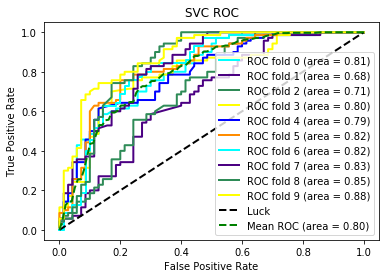

In [5]:
print("SVC")
svc = svm.SVC(kernel='rbf',degree=1,probability=True,C=2,class_weight="balanced")
crossvalidate(svc,X_std_res,y_std_res)
get_crossval_roc("SVC",svc,X_clean_res,y_clean_res)

#### Gauss Naive Bayes

(1400, 40)
Gaussian Naive Bayes
Cross Validation Precision: 0.79 (+/- 0.06)
Cross Validation Recall: 0.73 (+/- 0.05)
Cross Validation roc_auc: 0.84 (+/- 0.05)


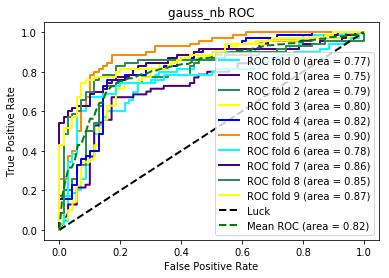

In [6]:
# Bagged Decision Trees to determine feature importance
# Use clean data, unstandardized and unscaled, because tree is robust to different scales
etcclf = ExtraTreesClassifier().fit(X_clean_res, y_clean_res)
    
# Select important features using sklearn SelectFromModel, vary treshold, good value turns out to be mean -> select overaverage important features
sfm = SelectFromModel(etcclf, prefit=True, threshold=0.01)

# Apply fitted transformation to datasets
SFMETC_X = sfm.transform(X_clean_res)
SFMETC_y = y_clean_res

# Print shape to see how many features have been selected
print(SFMETC_X.shape)

print("Gaussian Naive Bayes")
gauss_nb = GaussianNB()
crossvalidate(gauss_nb,SFMETC_X,SFMETC_y)
get_crossval_roc("gauss_nb",gauss_nb,SFMETC_X,SFMETC_y)

### Final Model with Bagging/Boosting

randomforest
Cross Validation Precision: 0.84 (+/- 0.16)
Cross Validation Recall: 0.80 (+/- 0.04)
Cross Validation roc_auc: 0.90 (+/- 0.10)


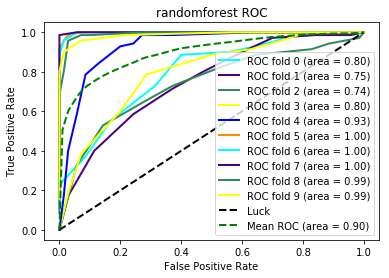

In [7]:
print("randomforest")
randomforest = RandomForestClassifier()
crossvalidate(randomforest,X_clean_res,y_clean_res)
get_crossval_roc("randomforest",randomforest,X_clean_res,y_clean_res)

extratrees
Cross Validation Precision: 0.87 (+/- 0.14)
Cross Validation Recall: 0.79 (+/- 0.03)
Cross Validation roc_auc: 0.91 (+/- 0.08)


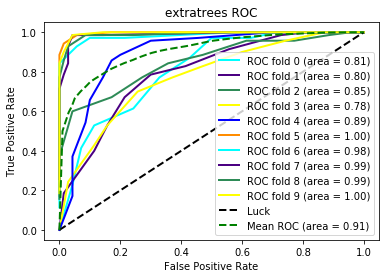

In [8]:
print("extratrees")
extratrees = ExtraTreesClassifier()
crossvalidate(extratrees,X_clean_res,y_clean_res)
get_crossval_roc("extratrees",extratrees,X_clean_res,y_clean_res)

GradientBoostingClassifier
Cross Validation Precision: 0.85 (+/- 0.17)
Cross Validation Recall: 0.86 (+/- 0.04)
Cross Validation roc_auc: 0.91 (+/- 0.09)


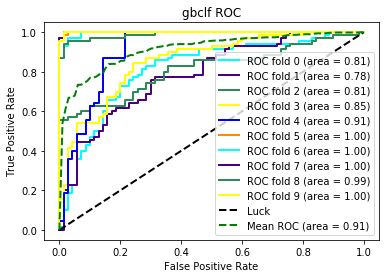

In [9]:
print("GradientBoostingClassifier")
gbclf = GradientBoostingClassifier(n_estimators=100)
crossvalidate(gbclf,X_clean_res,y_clean_res)
get_crossval_roc("gbclf",gbclf,X_clean_res,y_clean_res)

AdaBoostClassifier
Cross Validation Precision: 0.85 (+/- 0.16)
Cross Validation Recall: 0.82 (+/- 0.05)
Cross Validation roc_auc: 0.91 (+/- 0.09)


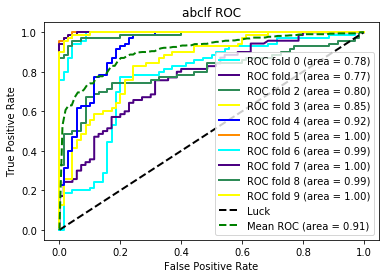

In [10]:
print("AdaBoostClassifier")
abclf = AdaBoostClassifier()
crossvalidate(abclf,X_clean_res,y_clean_res)
get_crossval_roc("abclf",abclf,X_clean_res,y_clean_res)

BaggingClassifier
Cross Validation Precision: 0.84 (+/- 0.16)
Cross Validation Recall: 0.81 (+/- 0.03)
Cross Validation roc_auc: 0.89 (+/- 0.10)


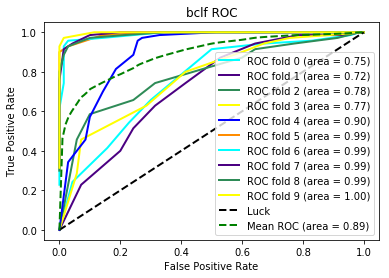

In [11]:
print("BaggingClassifier")
bclf = BaggingClassifier()
crossvalidate(bclf,X_clean_res,y_clean_res)
get_crossval_roc("bclf",bclf,X_clean_res,y_clean_res)